#Handeling Missing Value

In [ ]:
import numpy as np
import pandas as pd

missing_percentages = {'Credit_History': 8.143322, 'Self_Employed': 5.211726, 'LoanAmount': 3.583062, 'Dependents': 2.442997, 'Loan_Amount_Term': 2.280130, 'Gender': 2.117264, 'Married': 0.488599}

num_entries = 1000

data = {'Gender': np.random.choice(['Male', 'Female'], num_entries, p=[0.5, 0.5]),
        'Married': np.random.choice(['No', 'Yes'], num_entries, p=[0.6, 0.4]),
        'Dependents': np.random.choice(['0', '1', '2', '3+'], num_entries, p=[0.3, 0.3, 0.2, 0.2]),
        'Education': np.random.choice(['Graduate', 'Not Graduate'], num_entries),
        'Self_Employed': np.random.choice(['No', 'Yes'], num_entries, p=[0.8, 0.2]),
        'ApplicantIncome': np.random.randint(1000, 5000, num_entries),
        'CoapplicantIncome': np.random.uniform(0, 2000, num_entries),
        'LoanAmount': np.random.uniform(50, 300, num_entries),
        'Loan_Amount_Term': np.random.choice([360, 180, 120], num_entries, p=[0.7, 0.1, 0.2]),
        'Credit_History': np.random.choice([1.0, 0.0], num_entries, p=[0.6, 0.4]),
        'Property_Area': np.random.choice(['Urban', 'Rural', 'Semiurban'], num_entries),
        'Loan_Status': np.random.choice(['Y','N'], num_entries)}

df = pd.DataFrame(data)

# Inject missing values based on the specified percentages
for col, missing_pct in missing_percentages.items():
    mask = np.random.choice([True, False], size=df.shape[0], p=[missing_pct / 100, 1 - missing_pct / 100])
    df.loc[mask, col] = np.nan

df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,3+,Graduate,NaN,1614,1402.899584,58.139683,360.0,1.0,Semiurban,N
1,Female,No,0,Graduate,No,3389,809.339386,59.058032,360.0,1.0,Semiurban,Y
2,Male,No,2,Graduate,No,2956,313.894094,58.101544,360.0,1.0,Semiurban,N
3,Female,No,1,Graduate,No,1735,645.250817,99.410005,360.0,NaN,Rural,N
4,Female,No,0,Not Graduate,No,2379,728.763439,294.023291,360.0,1.0,Urban,N


In [ ]:
def random_sample_imputation(data):
    df_num=data.select_dtypes(include=np.number)
    df_cat=data.select_dtypes(exclude=np.number)

    for col in df_num:
        try:
            nan_value=data[col].isnull().sum()
            random_value=data[col].dropna().sample(nan_value,random_state=42)
            data.loc[data[col].isnull(),col]=random_value.values[0]
        except: continue

    for col in df_cat:
        try:
            nan_value=data[col].isnull().sum()
            random_value=data[col].dropna().sample(nan_value,random_state=42)
            data.loc[data[col].isnull(),col]=random_value.values[0]
        except: continue

    return data

df1=df.copy(deep=True)
df1 = random_sample_imputation(df1)
df1.isnull().sum()


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Drop basd on percentage of NaN value

In [ ]:
def drop_by_axis(data,axs,pct):
    #pct% or less columns not-nan rest of (100-pct)%  or more nan we drop that row
    if axs==0:
        min_cnt = int(pct*data.shape[1]+1)
    #pct% or less rows not-nan rest of (100-pct)%  or more nan we drop that column
    else:
        min_cnt = int(pct*df.shape[0]+1)

    try: data=data.dropna(axis=axs,thres=min_cnt)
    except: pass
    return data

df1=df.copy(deep=True)
pct,axs = 0.5 , 0 # row elemination
df1 = drop_by_axis(df1,axs,pct)
df1.isnull().sum()

Gender               20
Married               5
Dependents           21
Education             0
Self_Employed        57
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           28
Loan_Amount_Term     21
Credit_History       81
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
def CT_imputation(data):
    df_num=data.select_dtypes(include=np.number)
    df_cat=data.select_dtypes(exclude=np.number)
    for col in df_num:
        try:
            mean_=data[col].mean()
            std_=data[col].std()
            is_null_=data[col].isnull().sum()
            rand_=np.random.choice([mean_- std_,mean_ + std_,is_null_])
            data[col].fillna(rand_,inplace=True)
        except: continue
    for col in df_cat:
        try: data[col].fillna(data[col].mode()[0],inplace=True)
        except: continue
    return data


df1=df.copy(deep=True)
df1 = CT_imputation(df1)
df1.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Wilcoxon Signed-Rank Test
    In some cases, the data samples may be paired.

### Kruskal-Wallis H Test

    When working with significance tests, such as Mann-Whitney U and the
    Wilcoxon signed-rank tests, comparisons between data samples must
    be performed pair-wise.

    This can be inefficient if you have many data samples and you are only
    interested in whether two or more samples have a different distribution.

In [ ]:
import numpy as np
from scipy.stats import mannwhitneyu

def non_parametric(data, alpha=0.05):
    tmp = data.copy(deep=True)
    try:
        tmp.dropna(inplace=True)
        data1 = tmp.sample(frac=0.3)
        cond = tmp.isin(data1)
        tmp.drop(tmp[cond].index, inplace=True)
        data2 = tmp.sample(frac=len(data1)/len(tmp))
        stat, p = mannwhitneyu(data1, data2)
        if p > alpha:
            return True
        else:
            return False
    except:
        return False

def outlier_imputation_numerical(data, alpha=0.05):
    df_num = data.select_dtypes(include=np.number)
    for col in df_num:
        isnormal = non_parametric(data[col], alpha)
        if isnormal:
            mean_ = data[col].mean()
            std_ = data[col].std()
            right_tailed = mean_ + 3 * std_
            left_tailed = mean_ - 3 * std_
            data[col].fillna(value=right_tailed, inplace=True)
        else:
            q3 = data[col].quantile(0.75)
            q1 = data[col].quantile(0.25)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            data[col].fillna(value=upper_bound, inplace=True)

    return data

df1 = df.copy(deep=True)
df_num = outlier_imputation_numerical(df1)
df_num.isnull().sum()


Gender               20
Married               5
Dependents           21
Education             0
Self_Employed        57
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer #for multivariate imputation
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

In [ ]:
def algo_imputer(data):
    #rfg=RandomForestRegressor()
    #imputer=IterativeImputer(estimator=rfg,max_iter=8,random_state=42)
    imputer=KNNImputer(n_neighbors=10,weights='distance')
    data=imputer.fit_transform(data)
    print(imputer.feature_names_in_)
    return data

df1 = df.copy(deep=True)
df1 = df1.replace({'Gender':{'Male':0,'Female':1},
                'Married':{'No':0,'Yes':1},
                'Dependents':{'0':0,'1':1,'2':2,'3+':3},
                'Education':{'Graduate':1,'Not Graduate':0},
                'Self_Employed':{'No':0,'Yes':1},
                'Property_Area':{'Urban':2,'Rural':0,'Semiurban':1},
                'Loan_Status' : {'Y':1,'N':0}
                })
df_num = algo_imputer(df1)
df_num.shape

['Gender' 'Married' 'Dependents' 'Education' 'Self_Employed'
 'ApplicantIncome' 'CoapplicantIncome' 'LoanAmount' 'Loan_Amount_Term'
 'Credit_History' 'Property_Area' 'Loan_Status']


(1000, 12)

    Credit_History       8.143322
    Self_Employed        5.211726
    LoanAmount           3.583062
    Dependents           2.442997
    Loan_Amount_Term     2.280130
    Gender               2.117264
    Married              0.488599

#### Here 'Credit_History' column contains 8% null values so for prediction of null values the spliting of data will be,

    y_train: rows from data["Credit_History"] with non null values
    y_test: rows from data["Credit_History"] with null values
    X_train: Dataset except data["Credit_History"] features with non null values
    X_test: Dataset except data["Credit_History"] features with null values



In [ ]:
from sklearn.linear_model import LinearRegression


def predicting_nan(data):

    for col in data.columns:
        missing=data[col].isnull().sum()*100/len(data)
        model = LinearRegression()
        try:
            if missing > 0:
                tmp=data.copy(deep=True)
                tmp_test=tmp[tmp[col].isnull()]
                tmp.dropna(inplace=True)
                y_train=tmp[col]
                X_train=tmp.drop(col,axis=1)
                X_test=tmp_test.drop(col,axis=1)
                model.fit(X_train,y_train)
                y_pred=model.predict(X_test)
                data[col]=y_pred
        except: continue

    return data


df1=df.copy(deep=True)
print(df1.isnull().sum())
df = predicting_nan(df1)
print('\n\nAfter Imputation\n')
df1.isnull().sum()


Gender               20
Married               5
Dependents           21
Education             0
Self_Employed        57
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           28
Loan_Amount_Term     21
Credit_History       81
Property_Area         0
Loan_Status           0
dtype: int64


After Imputation



Gender               20
Married               5
Dependents           21
Education             0
Self_Employed        57
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           28
Loan_Amount_Term     21
Credit_History       81
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
def iqr_outlier_removal(data):
    for col in data.columns:
        q1=np.percentile(data[col],25,method = 'midpoint')
        q3=np.percentile(data[col],75,method = 'midpoint')
        iqr=q3-q1
        lower_bound=q1-1.5*iqr
        upper_bound=q3+1.5*iqr
        try:
            lower_bound_mask=np.where(data[col]<=lower_bound)
            upper_bound_mask=np.where(data[col]>=upper_bound)
            data[data[col]<lower_bound]=lower_bound
            data[data[col]>upper_bound]=upper_bound
        except: continue
    return data


df1 = df.copy(deep=True)
df1 = df1.replace({'Gender':{'Male':0,'Female':1},
                'Married':{'No':0,'Yes':1},
                'Dependents':{'0':0,'1':1,'2':2,'3+':3},
                'Education':{'Graduate':1,'Not Graduate':0},
                'Self_Employed':{'No':0,'Yes':1},
                'Property_Area':{'Urban':2,'Rural':0,'Semiurban':1},
                'Loan_Status' : {'Y':1,'N':0}
                })
df_num = iqr_outlier_removal(df1)
df_num.isnull().sum()

Gender               20
Married               5
Dependents           21
Education             0
Self_Employed        57
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           28
Loan_Amount_Term     21
Credit_History       81
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
df1 = df.copy(deep=True)
df1 = df1.replace({'Gender':{'Male':0,'Female':1},
                'Married':{'No':0,'Yes':1},
                'Dependents':{'0':0,'1':1,'2':2,'3+':3},
                'Education':{'Graduate':1,'Not Graduate':0},
                'Self_Employed':{'No':0,'Yes':1},
                'Property_Area':{'Urban':2,'Rural':0,'Semiurban':1},
                'Loan_Status' : {'Y':1,'N':0}
                })

X=df1.iloc[:,:-1]
y=df1.loc[:,'Loan_Status']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

from sklearn.impute import SimpleImputer

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Rest of your code remains the same
model=LogisticRegression(random_state=42,max_iter=1000,tol=0.001,solver='liblinear')
scaler = StandardScaler()
param_grid = {'logistic__C': np.logspace(-4, 4, 4)}
pipe = Pipeline(steps=[("scaler", scaler), ("logistic", model)])
gs = GridSearchCV(pipe, param_grid)
gs.fit(X_train_imputed, y_train)

print('Best parameter (CV score=%0.3f):' % gs.best_score_)
print(gs.best_params_)



Best parameter (CV score=0.481):
{'logistic__C': 0.0001}


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       170
           1       0.48      0.51      0.49       160

    accuracy                           0.49       330
   macro avg       0.49      0.49      0.49       330
weighted avg       0.49      0.49      0.49       330



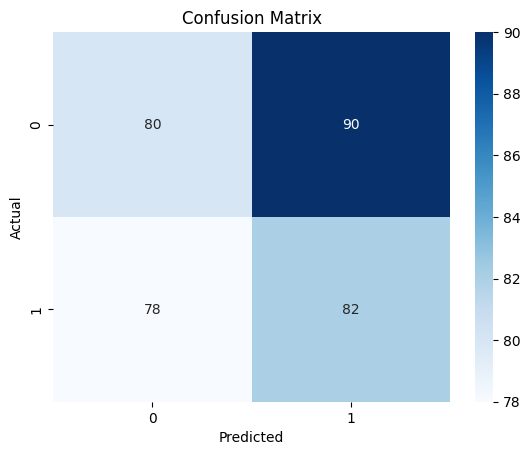

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Fit the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Print feature importance (if applicable)
if hasattr(model, 'feature_importances_'):
    print('Feature Importance:', model.feature_importances_)

# Print confusion matrix and classification report
cf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix (optional)
# You can use seaborn or matplotlib to create a heatmap of the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

folds=10
kf = KFold(shuffle=True,random_state=42,n_splits=folds)
cross_validation=cross_val_score(model,X_train_imputed,y_train, cv=kf,scoring='r2')
print(f"Cross-validated scores with splits = {folds} : {cross_validation}")
print(f"Mean value of {folds} cross validation score {np.mean(cross_validation)}")

Cross-validated scores with splits = 10 : [-1.32551595 -0.92114695 -1.09001783 -1.35405405 -1.27014652 -1.04190476
 -1.1712963  -1.09001783 -0.77930403 -1.03030303]
Mean value of 10 cross validation score -1.1073707243504765


In [ ]:
test = pd.DataFrame(X_test_imputed[-20:],columns=df1.columns[:-1])
test.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [ ]:
y_final=pd.DataFrame(model.predict(test),columns=['Loan_Status'])
y_final.tail(5)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Loan_Status
15,0
16,0
17,0
18,0
19,0


In [ ]:
#